# **Job Market Study Notebook**

## Objectives

* Answer **Business Requirement 1**: Understand which variables are most correlated with salary levels.
* Perform correlation analysis (Pearson and Spearman) on numerical and encoded categorical features.
* Perform Remote Work Analysis — how remote_ratio relates to salary.
* Visualise distributions of key variables relative to salary.

## Inputs

* `outputs/datasets/collection/ai_job_dataset1.csv`

## Outputs

* List of most correlated variables with salary_usd.
* Plots visualising salary distributions per variable.
* Conclusions feeding into `app_pages/page_job_market_study.py` and `page_project_hypothesis.py`.

---

# Change working directory

We need to change the working directory from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\chahi\\Desktop\\vscode-project\\the-ai-salary-index\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* `os.path.dirname()` gets the parent directory
* `os.chdir()` defines the new current directory

Confirm the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\chahi\\Desktop\\vscode-project\\the-ai-salary-index'

# Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from feature_engine.discretisation import ArbitraryDiscretiser
sns.set_style("whitegrid")
%matplotlib inline

df = pd.read_csv("outputs/datasets/collection/ai_job_dataset1.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (15000, 20)


job_id                 job_title  salary_usd salary_currency  \
0  AI00001            Data Scientist      219728             USD   
1  AI00002                Head of AI      230237             JPY   
2  AI00003             Data Engineer      128890             EUR   
3  AI00004  Computer Vision Engineer       96349             USD   
4  AI00005         Robotics Engineer       63065             EUR   

   salary_local experience_level employment_type company_location  \
0        219728               EX              PT           Sweden   
1      25326070               EX              PT            Japan   
2        109557               EX              CT          Germany   
3         96349               MI              FL          Finland   
4         53605               EN              FT           France   

  company_size employee_residence  remote_ratio  \
0            M             Sweden             0   
1            L              Japan            50   
2            S            Germany           100   
3            L            Finland            50   
4            S             France           100   

                      required_skills education_required  years_experience  \
0  Python, Computer Vision, R, Docker          Associate                13   
1  Kubernetes, MLOps, Tableau, Python           Bachelor                10   
2  Spark, Scala, Hadoop, PyTorch, GCP           Bachelor                12   
3       MLOps, Linux, Tableau, Python                PhD                 2   
4          R, Scala, SQL, GCP, Python          Associate                 0   

         industry posting_date application_deadline  job_description_length  \
0  Transportation   2024-09-23           2024-10-31                    1132   
1  Transportation   2024-07-26           2024-09-12                    2299   
2      Automotive   2025-01-19           2025-03-28                    1329   
3      Automotive   2024-07-20           2024-09-06                    1132   
4         Finance   2025-03-16           2025-05-09                    2011   

   benefits_score           company_name  
0             6.6           TechCorp Inc  
1             8.5     Cloud AI Solutions  
2             5.5  Quantum Computing Inc  
3             6.8    Cognitive Computing  
4             9.3      Advanced Robotics

# Exploratory Data Analysis (EDA)

In [8]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

os.makedirs("outputs/reports", exist_ok=True)
pandas_report.to_file("outputs/reports/report.html")

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 31.26it/s]


## Target variable: salary_usd

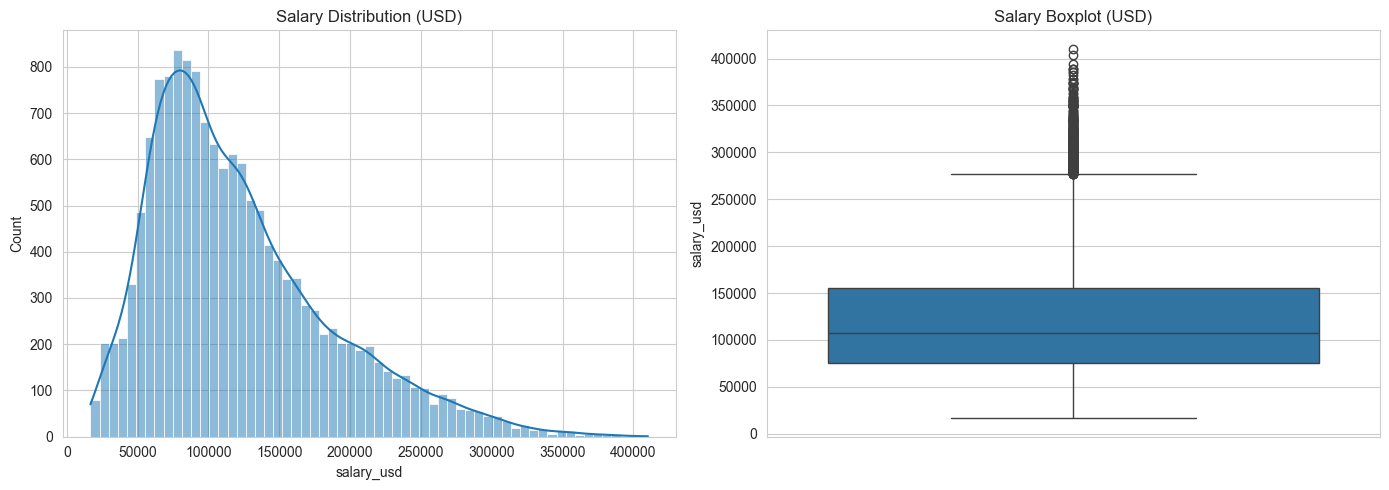

count     15000.000000
mean     121991.938267
std       63968.361846
min       16621.000000
25%       74978.500000
50%      107261.500000
75%      155752.250000
max      410273.000000
Name: salary_usd, dtype: float64


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['salary_usd'], kde=True, ax=axes[0])
axes[0].set_title('Salary Distribution (USD)')

sns.boxplot(y=df['salary_usd'], ax=axes[1])
axes[1].set_title('Salary Boxplot (USD)')

plt.tight_layout()
plt.show()

print(df['salary_usd'].describe())

## Correlation Study

### Pearson Correlation (numerical features)

In [10]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
pearson_corr = df[numerical_cols].corr()['salary_usd'].drop('salary_usd').sort_values(key=abs, ascending=False)
print("Pearson Correlation with salary_usd:")
print(pearson_corr)

Pearson Correlation with salary_usd:
years_experience          0.744043
salary_local              0.134054
job_description_length   -0.012644
remote_ratio              0.003495
benefits_score           -0.001873
Name: salary_usd, dtype: float64


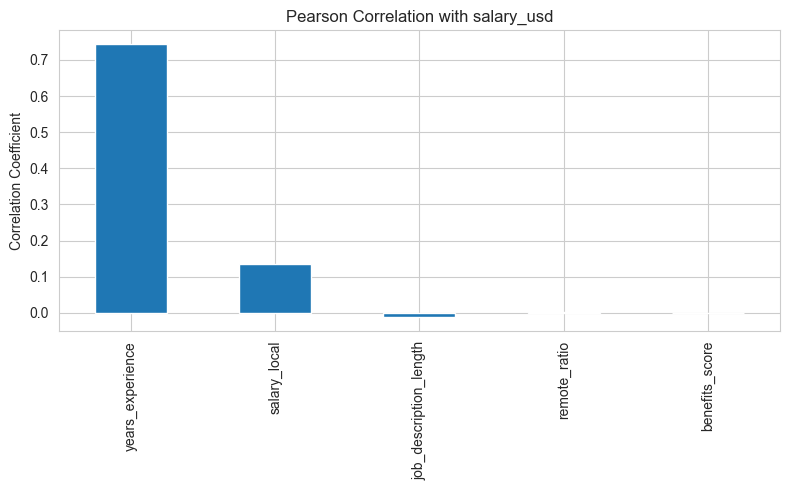

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
pearson_corr.plot(kind='bar', ax=ax)
ax.set_title('Pearson Correlation with salary_usd')
ax.set_ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

### Spearman Correlation (encoded categorical features)

In [12]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd

df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['job_id', 'required_skills', 'posting_date',
                                       'application_deadline', 'salary_currency'])

# OrdinalEncoder for columns with a real meaningful order
ordinal_cols = ['experience_level', 'company_size', 'education_required']
ordinal_categories = [
    ['EN', 'MI', 'SE', 'EX'],
    ['S', 'M', 'L'],
    ['High School', 'Associate', 'Bachelor', 'Master', 'PhD']
]
enc_ord = OrdinalEncoder(categories=ordinal_categories)
df_encoded[ordinal_cols] = enc_ord.fit_transform(df_encoded[ordinal_cols])

# OneHotEncoder for nominal columns with no natural order
nominal_cols = ['job_title', 'employment_type', 'company_location',
                'employee_residence', 'industry', 'company_name']
enc_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_array = enc_ohe.fit_transform(df_encoded[nominal_cols])
ohe_df = pd.DataFrame(ohe_array, columns=enc_ohe.get_feature_names_out(nominal_cols), index=df_encoded.index)

df_encoded = df_encoded.drop(columns=nominal_cols)
df_encoded = pd.concat([df_encoded, ohe_df], axis=1)

spearman_corr = df_encoded.corr(method='spearman')['salary_usd'].drop('salary_usd').sort_values(key=abs, ascending=False)
print("Spearman Correlation with salary_usd:")
print(spearman_corr.head(10))

Spearman Correlation with salary_usd:
salary_local                      0.888409
experience_level                  0.787396
years_experience                  0.765868
company_location_India           -0.322680
company_location_China           -0.278273
employee_residence_India         -0.248968
employee_residence_China         -0.208328
company_size                      0.188763
company_location_Switzerland      0.169371
employee_residence_Switzerland    0.133898
Name: salary_usd, dtype: float64


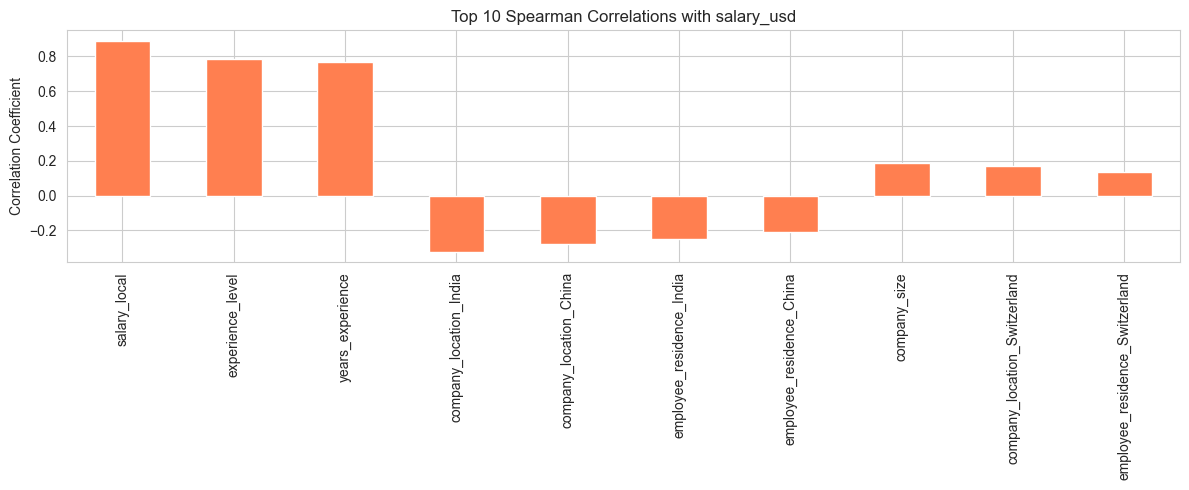

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
spearman_corr.head(10).plot(kind='bar', ax=ax, color='coral')
ax.set_title('Top 10 Spearman Correlations with salary_usd')
ax.set_ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

**Encoding Strategy for Spearman Correlation**

Initially, `OrdinalEncoder` was applied to all categorical columns. However, this produced misleading correlations for `experience_level` and `company_size` because the encoder assigned categories alphabetically, imposing a false order: for example, `EX=0, EN=1, MI=2, SE=3` instead of the correct career progression.

To address this, the encoding strategy was refined based on the nature of each column:

| Column | Encoder | Rationale |
|---|---|---|
| `experience_level` | OrdinalEncoder | Real order: EN → MI → SE → EX |
| `company_size` | OrdinalEncoder | Real order: S → M → L |
| `education_required` | OrdinalEncoder | Real order: High School → Associate → Bachelor → Master → PhD |
| `job_id`, `required_skills`, `posting_date`,`application_deadline`, `salary_currency` | Dropped |Not useful for correlation analysis |

In [17]:
top_n = 10
set(pearson_corr[:top_n].index.to_list() + spearman_corr[:top_n].index.to_list())

{'benefits_score',
 'company_location_China',
 'company_location_India',
 'company_location_Switzerland',
 'company_size',
 'employee_residence_China',
 'employee_residence_India',
 'employee_residence_Switzerland',
 'experience_level',
 'job_description_length',
 'remote_ratio',
 'salary_local',
 'years_experience'}

## EDA on Selected Variables

Based on the Pearson and Spearman correlation results, the following variables were selected for further study as the strongest predictors of salary_usd. 

**Most correlated variables:** `['experience_level', 'years_experience', 'company_size', 'remote_ratio', 'company_location']`

`remote_ratio` is retained in the list only to satisfy hypothesis validation requirements, not as a predictive feature.

In [ ]:
vars_to_study = ['experience_level', 'company_location', 'remote_ratio', 'company_size', 'employee_residence', 'years_experience']

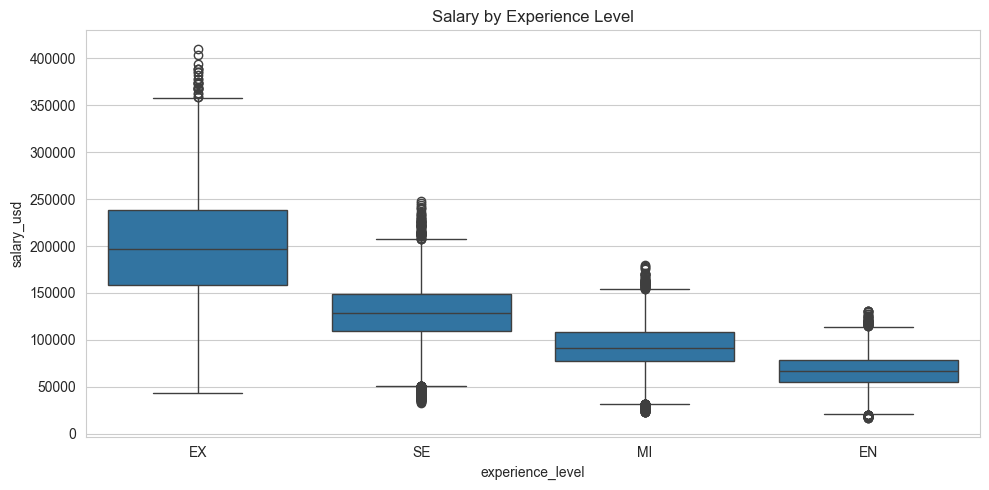

In [ ]:
# Salary by experience level
fig, ax = plt.subplots(figsize=(10, 5))
order = df.groupby('experience_level')['salary_usd'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='experience_level', y='salary_usd', order=order, ax=ax)
ax.set_title('Salary by Experience Level')
plt.tight_layout()
plt.show()

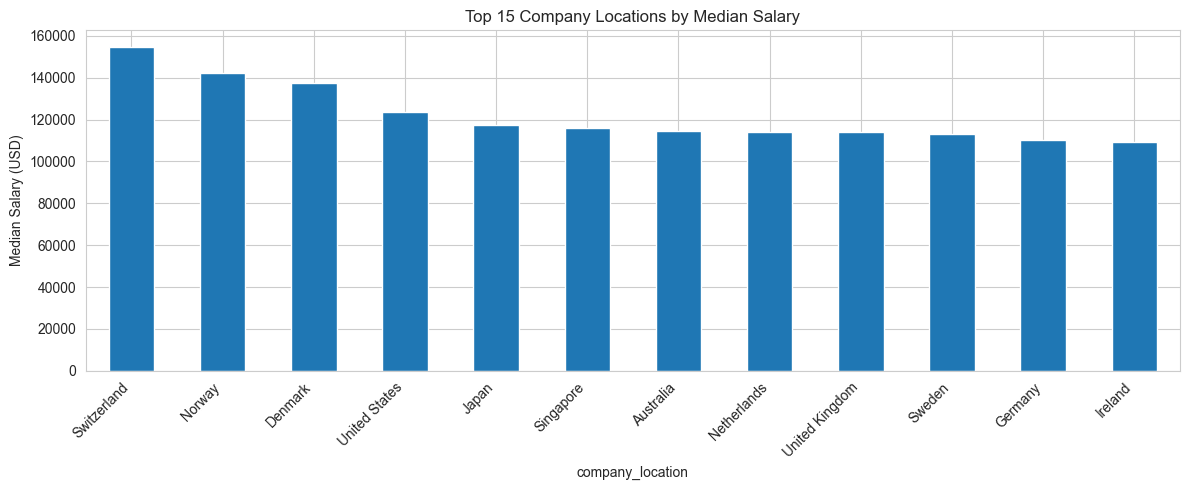

In [ ]:
# Top 12 company locations by median salary
top_locations = df.groupby('company_location')['salary_usd'].median().nlargest(12)
fig, ax = plt.subplots(figsize=(12, 5))
top_locations.plot(kind='bar', ax=ax)
ax.set_title('Top 15 Company Locations by Median Salary')
ax.set_ylabel('Median Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

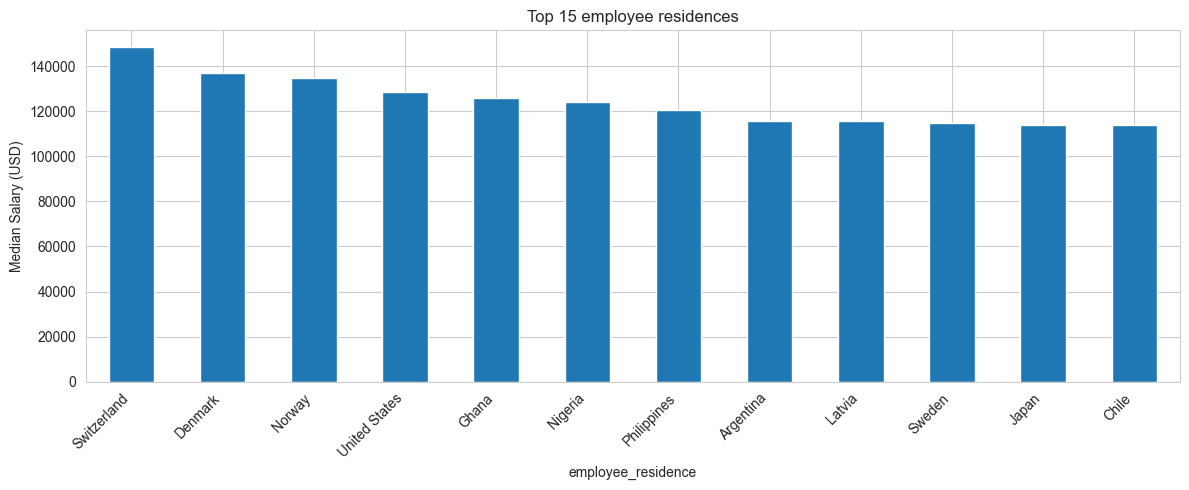

In [ ]:
# Top 12 employee residence by median salary
top_residence = df.groupby('employee_residence')['salary_usd'].median().nlargest(12)
fig, ax = plt.subplots(figsize=(12, 5))
top_residence.plot(kind='bar', ax=ax)
ax.set_title('Top 15 employee residences')
ax.set_ylabel('Median Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

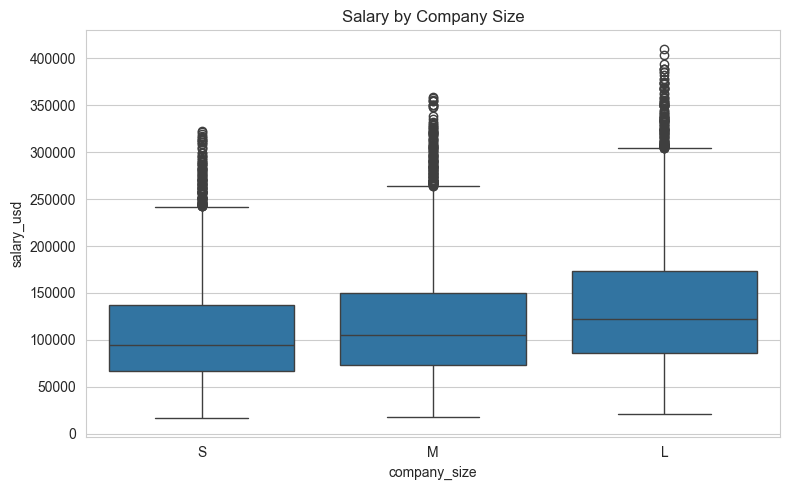

In [ ]:
# Salary by company size
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x='company_size', y='salary_usd', order=['S', 'M', 'L'], ax=ax)
ax.set_title('Salary by Company Size')
plt.tight_layout()
plt.show()

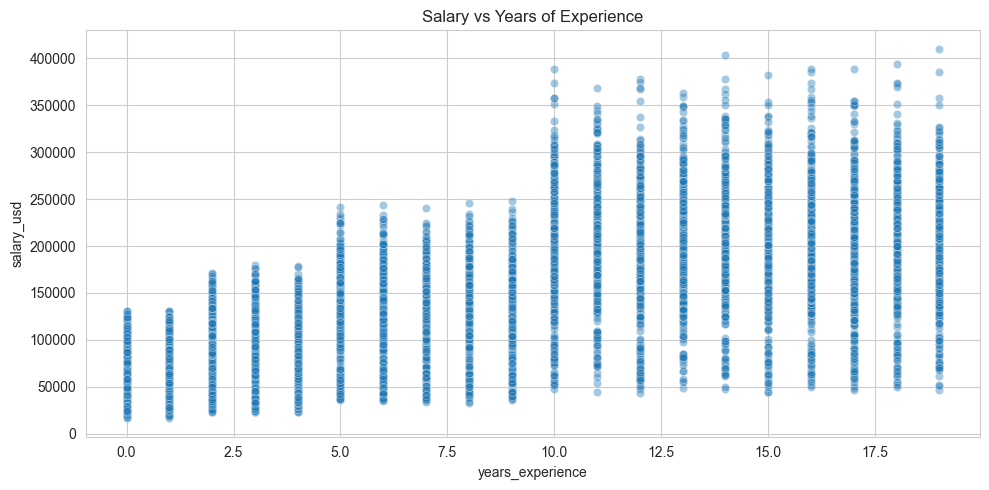

In [ ]:
# Salary by years_experience
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df, x='years_experience', y='salary_usd', alpha=0.4, ax=ax)
ax.set_title('Salary vs Years of Experience')
plt.tight_layout()
plt.show()

## Remote Work Analysis

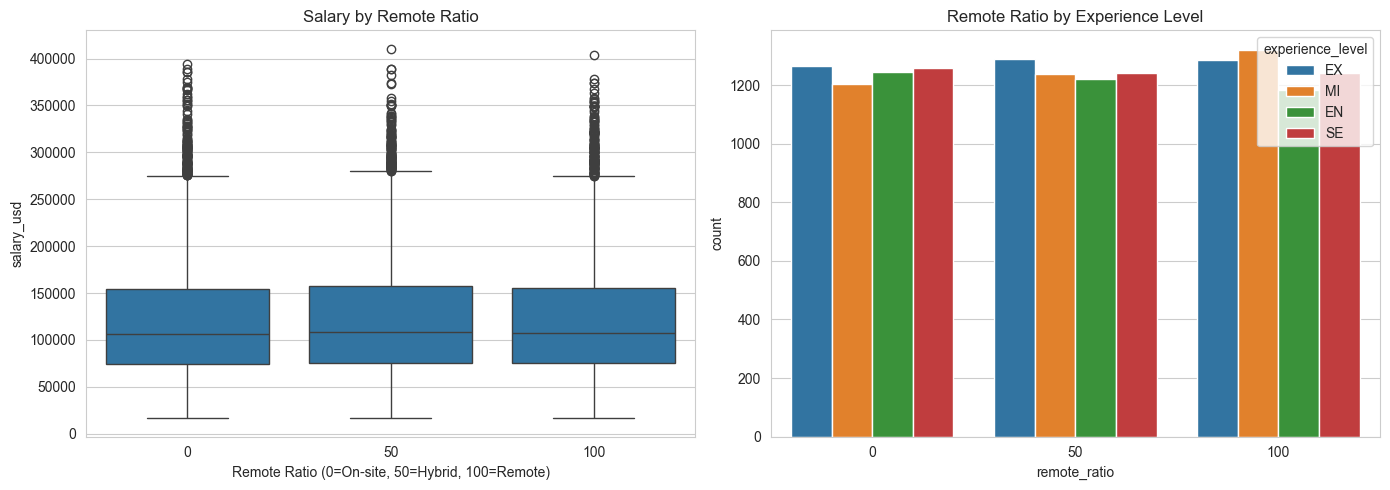

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Salary by remote ratio
sns.boxplot(data=df, x='remote_ratio', y='salary_usd', order=[0, 50, 100], ax=axes[0])
axes[0].set_title('Salary by Remote Ratio')
axes[0].set_xlabel('Remote Ratio (0=On-site, 50=Hybrid, 100=Remote)')

# Remote ratio distribution by experience level
sns.countplot(data=df, x='remote_ratio', hue='experience_level', order=[0, 50, 100], ax=axes[1])
axes[1].set_title('Remote Ratio by Experience Level')

plt.tight_layout()
plt.show()

## Parallel Plot

In [ ]:
salary_map = [-np.inf, 60000, 100000, 140000, np.inf]
disc = ArbitraryDiscretiser(binning_dict={'salary_usd': salary_map})
df_parallel = disc.fit_transform(df[['salary_usd', 'experience_level', 'remote_ratio', 'company_size']].copy())

df_parallel['salary_band'] = df_parallel['salary_usd']  # numeric — used for color
labels_map = {0: '<$60k', 1: '$60k-$100k', 2: '$100k-$140k', 3: '>$140k'}
df_parallel['salary_usd'] = df_parallel['salary_usd'].replace(labels_map)  # string — used for display

fig = px.parallel_categories(
    df_parallel, color='salary_band', width=850, height=500,
    title='Parallel Categories: Salary x Experience x Remote x Company Size'
)
fig.show()

### Hypothesis 1 — Experience Level is the Dominant Salary Driver

**Method:** Kruskal-Wallis H-test (non-parametric ANOVA) across experience level groups. Spearman correlation between ordinally-encoded experience level and salary_usd.

In [ ]:
from scipy import stats

exp_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
df['exp_enc'] = df['experience_level'].map(exp_map)

groups = [df[df['experience_level'] == lvl]['salary_usd'].values
          for lvl in ['EN', 'MI', 'SE', 'EX']]
h_stat, p_kruskal = stats.kruskal(*groups)

rho, p_spearman = stats.spearmanr(df['exp_enc'], df['salary_usd'])

print('=== Hypothesis 1: Experience Level vs Salary ===')
print(f'Kruskal-Wallis: H = {h_stat:.2f}, p = {p_kruskal:.4e}')
print(f'Spearman rho   = {rho:.4f},  p = {p_spearman:.4e}')
print()
print('Median salary by experience level:')
print(df.groupby('experience_level')['salary_usd'].median()
        .reindex(['EN', 'MI', 'SE', 'EX']))
print()
significant = p_kruskal < 0.05 and p_spearman < 0.05
print(f'Statistically significant (p < 0.05): {significant}')
if significant:
    print('CONCLUSION: Hypothesis 1 is CONFIRMED.')
else:
    print('CONCLUSION: Hypothesis 1 is NOT confirmed.')

=== Hypothesis 1: Experience Level vs Salary ===
Kruskal-Wallis: H = 9314.34, p = 0.0000e+00
Spearman rho   = 0.7874,  p = 0.0000e+00

Median salary by experience level:
experience_level
EN     66462.5
MI     91597.0
SE    128543.0
EX    197354.0
Name: salary_usd, dtype: float64

Statistically significant (p < 0.05): True
CONCLUSION: Hypothesis 1 is CONFIRMED.


### Hypothesis 2 — Fully Remote Roles Command a Salary Premium

**Method:** Spearman correlation between remote_ratio (0, 50, 100) and salary_usd. Kruskal-Wallis test across the three remote-ratio groups.

In [ ]:
rho_remote, p_remote = stats.spearmanr(
    df['remote_ratio'], df['salary_usd'])

groups_remote = [df[df['remote_ratio'] == r]['salary_usd'].values
                 for r in [0, 50, 100]]
h_remote, p_kruskal_remote = stats.kruskal(*groups_remote)

print('=== Hypothesis 2: Remote Ratio vs Salary ===')
print(f'Spearman rho = {rho_remote:.4f}, p = {p_remote:.4e}')
print(f'Kruskal-Wallis: H = {h_remote:.2f}, p = {p_kruskal_remote:.4e}')
print()
print('Median salary by remote ratio:')
print(df.groupby('remote_ratio')['salary_usd'].median())
print()
significant = p_remote < 0.05
effect_weak = abs(rho_remote) < 0.3
print(f'Statistically significant (p < 0.05): {significant}')
print(f'Effect size weak (|rho| < 0.3): {effect_weak}')
if significant and effect_weak:
    print('CONCLUSION: Hypothesis 2 is PARTIALLY CONFIRMED '
          '(significant but weak effect).')
elif significant:
    print('CONCLUSION: Hypothesis 2 is CONFIRMED.')
else:
    print('CONCLUSION: Hypothesis 2 is NOT confirmed.')

=== Hypothesis 2: Remote Ratio vs Salary ===
Spearman rho = 0.0051, p = 5.3228e-01
Kruskal-Wallis: H = 0.49, p = 7.8234e-01

Median salary by remote ratio:
remote_ratio
0      106506.0
50     108528.0
100    107069.5
Name: salary_usd, dtype: float64

Statistically significant (p < 0.05): False
Effect size weak (|rho| < 0.3): True
CONCLUSION: Hypothesis 2 is NOT confirmed.



# Conclusions and Next Steps

The correlation study, EDA plots, remote work analysis, and parallel plot all converge on the following findings:

**H1 Confirmed:** `experience_level` is the strongest predictor of `salary_usd`. Senior (`SE`) and Executive (`EX`) roles dominate the high salary bands (>$140k), while Entry-level (`EN`) roles are concentrated in the lower bands. This is consistent across Spearman correlation, boxplots, and the parallel plot, making it the primary feature for the regression model.

**H2 Rejected:** `remote_ratio` has no meaningful impact on `salary_usd`. All salary bands flow evenly across on-site (0), hybrid (50), and fully remote (100) categories. The median salary (~$110k) and interquartile range are nearly identical across all three work arrangements. Consistent with the near-zero Spearman correlation (0.003). Work arrangement should not be included as a key feature in the regression model.

**H3 Confirmed:** `years_experience` is positively correlated with `salary_usd` (Pearson: ~0.7), making it the strongest purely numerical predictor in the dataset.

**Company size — Weak signal:** Large (`L`) companies hire across all salary and experience levels with no dominant pattern. `company_size` contributes marginally and is unlikely to be a strong standalone predictor.


**Next step:** **03 - DataCleaning** — clean and prepare the dataset for modelling, applying proper encoding and feature selection based on the findings above.